# Data Science project - OD Travel time Predictor
Students : Alix MEULOT, Anaëlle MARTY, Ghislain MUTABAZI, Nathan DAMBREVILLE

## <u> **I/ Data preprocessing** </u>
###  <u> **0 - Imports** </u>
#### a/ Libraries import

In [1]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn import tree

print("✅ Libraries successfully imported")

✅ Libraries successfully imported


#### b/ `read_whole_pandas_df` function import

In [2]:
alt_path = 'data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv'

def read_whole_pandas_df(path, alternative_path=alt_path, sep = ",", enc = None, columns = None, parse_dates=None, format=None, alternative_dataset = False):
    if alternative_dataset:
        all_files = [alternative_path]
    else:
        all_files = glob.glob(path)
    li = []
    for filename in all_files:
        print("Reading file {}".format(filename))
        df = pd.read_csv(filename, encoding = enc, sep=sep, names = columns, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

print(f"✅ read_whole_pandas_df function defined, with alternative_path set as:\n{alt_path}")

✅ read_whole_pandas_df function defined, with alternative_path set as:
data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv


#### c/ Data import

In [3]:
# Data folder's path
BASE_PATH = r"data/"
# Velo'v data's path
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
# Velo'v stations locations file's path
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
# Lyon's contours dataset's path
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
# Coordinates of the center of Lyon
LYON_CENTER = (45.764043, 4.835659)
# Importing the data into a dataframe
df_lyon = read_whole_pandas_df(LYON_PATH, alternative_path=alt_path, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"], alternative_dataset=False)
print(f"✅ All datasets were successfully imported")

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
print(f"✅ The columns |date_exit| and |date_return| were successfully converted to datetime.")
df_lyon.head()

Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T1.csv
Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T2.csv
Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T3.csv
Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T4.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T1.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T2.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T3.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T4.csv
✅ All datasets were successfully imported
✅ The columns |date_exit| and |date_return| were successfully converted to datetime.


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00


###  <u> **1 - Adding intermediate columns** </u>
#### a/ Floored datetime column

In [4]:
df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")
df_lyon.head()

C:\Users\ndamb\AppData\Local\Temp\ipykernel_24600\2808807517.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01 00:00:00+01:00
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01 00:00:00+01:00
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01 00:00:00+01:00
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01 00:00:00+01:00
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01 00:00:00+01:00


#### b/ `day`, `month`, and `travel_time` columns
**NB:** The travel time is computed in minutes.

In [5]:
df_lyon['day'] = df_lyon.date_exit.dt.day_of_week
df_lyon['month'] = df_lyon.date_exit.dt.month
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,8.0
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,30.0
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,15.0


###  <u> **2 - Adding the `distance` column** </u>

In [6]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]
df_lyon.head()

c:\Users\ndamb\anaconda3\envs\DataSciencesFurno\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


idstation,7024,10063,10021,8038,7045,6045,8056,8015,7057,7007,...,3035,6039,30002,12005,2027,3040,7017,3138,10049,10044
idstation,,,,,,,,,,,,,,,,,,,,,
7024,0.000000,3672.322221,4038.271301,2101.306115,1728.531155,2359.789599,1897.619990,2771.548411,1581.022503,1739.714329,...,1487.311727,2209.079367,8316.839400,7914.027093,1190.596433,1448.733485,1397.488839,1707.214746,4936.861621,5241.842046
10063,3672.322221,0.000000,367.937601,1918.014222,5276.485492,2393.483029,3362.975962,2193.760999,4699.773041,5159.729411,...,2185.076724,2763.907648,6395.079493,4458.602747,4860.315824,2233.220170,4667.580451,2109.599779,1478.056510,2520.604551
10021,4038.271301,367.937601,0.000000,2269.206815,5644.183932,2665.024201,3700.574285,2477.416757,5062.122623,5525.999425,...,2550.967781,3042.980467,6250.871362,4115.750370,5225.466883,2596.741636,5032.708705,2457.739820,1175.815415,2354.611591
8038,2101.306115,1918.014222,2269.206815,0.000000,3484.503141,2327.918947,1467.055847,883.373258,2817.475111,3322.282657,...,940.820395,2518.623358,7840.242909,6376.168575,3252.453650,1066.873708,2814.886550,1368.271058,3379.142600,4169.994273
7045,1728.531155,5276.485492,5644.183932,3484.503141,0.000000,4061.439765,2522.986998,3875.840707,919.283986,340.362043,...,3133.747731,3865.225819,9954.924357,9612.529985,932.679947,3123.005262,758.389211,3425.591997,6614.809720,6970.331063


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0,1137.895337
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,8.0,1873.815972
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,30.0,2777.866158
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0,3962.183210
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,15.0,1352.710257


###  <u> **3 - Filtering** </u>

In [7]:
# Creating a `speed` column based on the travel time and the distance (values in km/h for future readability)
df_lyon["speed"] = (df_lyon["distance"]/1000) / (df_lyon["travel_time"]/60)
# Filtering the data where the speed is below 10 km/h or above 30 km/h
df_lyon = df_lyon[df_lyon.speed.between(10,30)]
# Filtering the travels where the exit station and the return station are identical
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]

print("There are ", df_lyon.shape[0], "travels after filtering.")
df_lyon.sample(10)

There are  6417529 travels after filtering.


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance,speed
145947,3067,3067 - HACHETTE,2019-01-10 08:37:00+01:00,10028.0,10028 - ECOLE DE MUSIQUE,2019-01-10 08:47:00+01:00,2019-01-10 08:00:00+01:00,3.0,1.0,10.0,1803.514286,10.821086
11965843,7003,7003 - GAMBETTA / GARIBALDI,2020-07-23 06:37:00+02:00,8015.0,8015 - JEAN XXIII,2020-07-23 06:49:00+02:00,2020-07-23 06:00:00+02:00,3.0,7.0,12.0,2106.567283,10.532836
2090132,7034,7034 - PISCINE DU RHÔNE,2019-04-02 08:17:00+02:00,9011.0,9011 - CONSERVATOIRE,2019-04-02 08:31:00+02:00,2019-04-02 08:00:00+02:00,1.0,4.0,14.0,2677.218416,11.473793
11999035,5007,5007 - PLACE DE TRION,2020-07-24 08:46:00+02:00,5002.0,5002 - PLACE DES COMPAGNONS DE LA CHANSON,2020-07-24 08:53:00+02:00,2020-07-24 08:00:00+02:00,4.0,7.0,7.0,1293.484674,11.087011
3471988,6020,6020 - MUSÉE GUIMET,2019-05-28 15:03:00+02:00,9044.0,9044 - MASSET / SAINT-PIERRE DE VAISE,2019-05-28 15:24:00+02:00,2019-05-28 15:00:00+02:00,1.0,5.0,21.0,3724.277126,10.640792
14835742,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2020-11-11 13:39:00+01:00,2025.0,2025 - MERCIÈRE / FERRANDIÈRE,2020-11-11 13:45:00+01:00,2020-11-11 13:00:00+01:00,2.0,11.0,6.0,1408.553730,14.085537
850990,2025,2025 - MERCIÈRE / FERRANDIÈRE,2019-02-12 23:02:00+01:00,3097.0,3097 - AUGAGNEUR / FOSSE AUX OURS,2019-02-12 23:06:00+01:00,2019-02-12 23:00:00+01:00,1.0,2.0,4.0,782.393263,11.735899
64212,10060,10060 - SAINT EXUPÉRY,2019-01-05 16:05:00+01:00,3005.0,3005 - SAXE / GAMBETTA,2019-01-05 16:15:00+01:00,2019-01-05 16:00:00+01:00,5.0,1.0,10.0,2452.621060,14.715726
14757538,9032,9032 - PLACE DU PORT MOUTON,2020-11-05 15:31:00+01:00,9011.0,9011 - CONSERVATOIRE,2020-11-05 15:34:00+01:00,2020-11-05 15:00:00+01:00,3.0,11.0,3.0,509.617895,10.192358
12383520,10019,10019 - 4 AOUT / RACINE,2020-08-11 08:40:00+02:00,3006.0,3006 - VILLETTE / SAINT-ANTOINE,2020-08-11 08:47:00+02:00,2020-08-11 08:00:00+02:00,1.0,8.0,7.0,1228.431737,10.529415


Average speed of the filtered data:  12.21 km/h
Estimated time for a 15km travel:  74 minutes


c:\Users\ndamb\anaconda3\envs\DataSciencesFurno\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


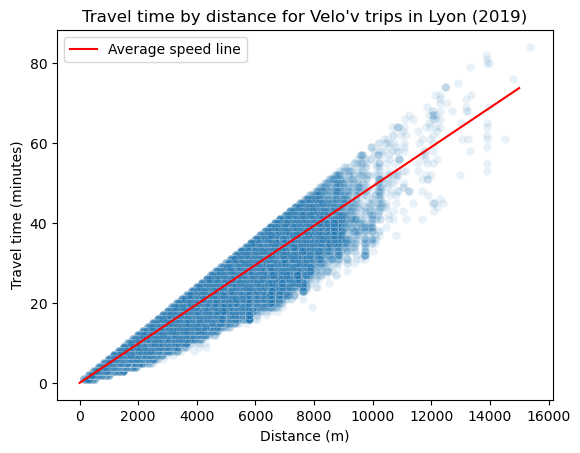

In [8]:
# Displaying a scatter graph of the travel time by the distance
sns.scatterplot(data=df_lyon, x="distance", y="travel_time", alpha=0.1)
plt.title("Travel time by distance for Velo'v trips in Lyon (2019)")
plt.xlabel("Distance (m)")
plt.ylabel("Travel time (minutes)")
# Adding the average speed line computed from the filtered data
avg_speed = df_lyon["speed"].sum() / (df_lyon["speed"].count())  # in km/h
print("Average speed of the filtered data: ", round(avg_speed,2), "km/h")
print("Estimated time for a 15km travel: ", round(60*15/avg_speed), "minutes")
plt.plot([0, 15000], [0, 60*15/(avg_speed)], color='red', label='Average speed line')
plt.legend()
plt.show()

## <u> **II/ Regression modelling** </u>
###  <u> **1 - Model 0 // Simple linear regression** </u>
#### a/ Model definition

In [9]:
# STEP 1 - GIVE IT A NAME

y = df_lyon['travel_time']
X = df_lyon[['distance']]

# STEP 2 - GIVE IT A NAME

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# STEP 3 - GIVE IT A NAME AND COMMENT ON EACH LINE

model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 

# Displaying the intercept with minutes (rounded to the lower value) and seconds and the average speed of the biker in km/h
print("The model's intercept is: ", int(model.intercept_), "minutes and", int((model.intercept_%1)*60), "seconds")
print("The estimated biker goes at: ", int(360/(model.coef_[0]*60))/100, "km/h in average")

# STEP 4 - GIVE IT A NAME
s_validation = pd.Series({
    'R²': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
})
s_validation

The model's intercept is:  0 minutes and 8 seconds
The estimated biker goes at:  12.13 km/h in average


R²     0.930899
MSE    2.506544
MAE    1.130357
dtype: float64

In [10]:
estimated_time_15km = model.intercept_ + 15000*model.coef_[0]
print("Estimated time for a 5km travel on bike: ", round(estimated_time_15km), "minutes")

Estimated time for a 5km travel on bike:  74 minutes


In [11]:
# Plotting a scatter graph of the travels' distance and duration (i.e. travel time) and the line of our regression model
## /!\ Code below runs in 5min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_lyon, alpha=0.1, label='Data points')
#sns.lineplot(x=X_test['distance'], y=y_pred, color='red', label='Regression line')
#plt.title('Travel Time vs Distance (with Regression Line)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Future functions

In [12]:
from functions.modelling_functions import *

###  <u> **1 - Model 1 // Multiple linear regression** </u>
#### a/ Adding the day of the week parameter

In [13]:
# Extracting a subset of our original dataframe with only the columns at use
df_model1 = df_lyon[['distance', 'travel_time', 'datetime_1h', 'day']].copy()
# Converting day to integer type
df_model1['day'] = df_model1['day'].astype(int)
df_model1.sample(5)

,distance,travel_time,datetime_1h,day
14213014,1273.794574,6.0,2020-10-11 18:00:00+02:00,6
6497442,681.129473,3.0,2019-10-05 10:00:00+02:00,5
824168,1016.939519,6.0,2019-02-11 21:00:00+01:00,0
3446026,1353.769636,7.0,2019-05-27 15:00:00+02:00,0
6628882,2371.265526,13.0,2019-10-09 20:00:00+02:00,2


In [14]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model1_dummies = pd.get_dummies(df_model1, columns=['day'], drop_first=True, dtype="int")
df_model1_dummies.sample(5)

,distance,travel_time,datetime_1h,day_1,day_2,day_3,day_4,day_5,day_6
8704284,733.090733,4.0,2020-01-14 14:00:00+01:00,1,0,0,0,0,0
7295973,2857.792108,16.0,2019-11-05 23:00:00+01:00,1,0,0,0,0,0
859048,1538.060350,5.0,2019-02-13 10:00:00+01:00,0,1,0,0,0,0
10827551,1349.415930,7.0,2020-06-08 23:00:00+02:00,0,0,0,0,0,0
611910,932.888307,5.0,2019-02-01 11:00:00+01:00,0,0,0,1,0,0


,Coefficient
day_5,0.060680
day_6,0.050378
day_4,0.014320
day_1,0.010104
day_3,0.008897
distance,0.004942
day_2,0.002684
intercept,0.123930


R²     0.930908
MSE    2.506225
MAE    1.130378
dtype: float64

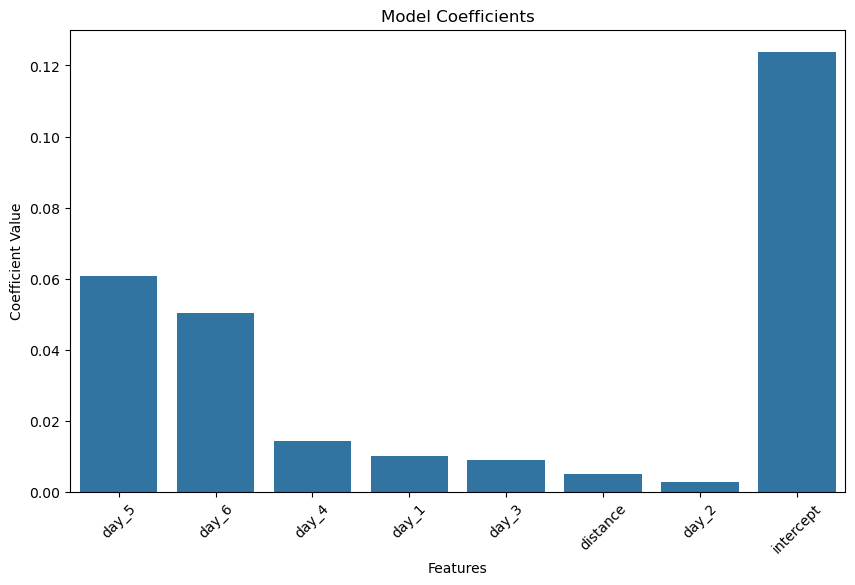

In [15]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model1_dummies['travel_time']
X = df_model1_dummies.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model1_day = LinearRegression()
model1_day.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1 = model1_day.predict(X_test)
s_model1_validation = build_validation_serie(y_test, y_pred_model1)
display(s_model1_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

## Plotting a scatter graph of the travels' distance and duration (i.e. travel time)
## and the lines of our multi-linear regression model, with different colors for each day of the week
## /!\ Code below runs in 15min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_model1_dummies, alpha=0.01, label='Data points')
#for day in range(1, 7):
#    day_columns = [col for col in X_test.columns if col.startswith('day_')]
#    day_dummies = np.zeros((len(X_test), len(day_columns)))
#    if day - 1 < len(day_columns):
#        day_dummies[:, day - 1] = 1
#    X_temp = X_test.copy()
#    X_temp[day_columns] = day_dummies
#    y_pred_day = model1_day.predict(X_temp)
#    sns.lineplot(x=X_test['distance'], y=y_pred_day, label=f'Day {day}')
#plt.title('Travel Time vs Distance (with Regression Lines for Each Day)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Adding the time of day parameter

In [16]:
# Adding the dummies column indicating which hour of the day it is
df_model1['hour'] = df_model1['datetime_1h'].dt.hour
df_model1_dummies_hour = pd.get_dummies(df_model1, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model1_dummies_hour.sample(5)

,distance,travel_time,datetime_1h,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
10543919,648.875175,3.0,2020-05-26 20:00:00+02:00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
174317,4315.321063,20.0,2019-01-11 13:00:00+01:00,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1909763,814.334146,4.0,2019-03-26 20:00:00+01:00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14727170,909.280785,5.0,2020-11-03 14:00:00+01:00,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7543273,3442.343197,20.0,2019-11-17 10:00:00+01:00,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


,Coefficient
hour_18,0.142921
hour_16,0.137413
hour_17,0.133770
hour_15,0.103542
hour_19,0.096276
hour_14,0.086571
hour_8,0.078695
day_5,0.067458
day_6,0.053624
hour_1,0.053604


R²     0.931203
MSE    2.495517
MAE    1.127761
dtype: float64

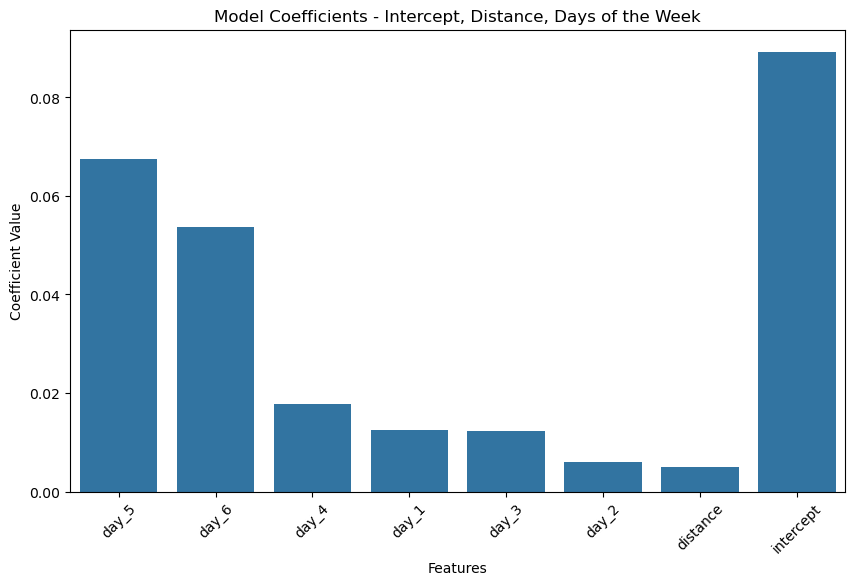

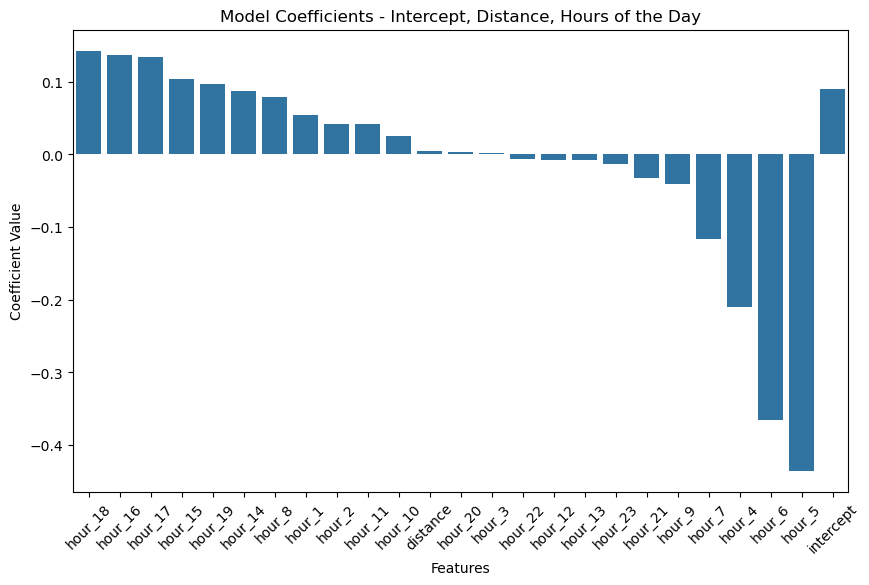

C:\Users\ndamb\AppData\Local\Temp\ipykernel_24600\2472390057.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)


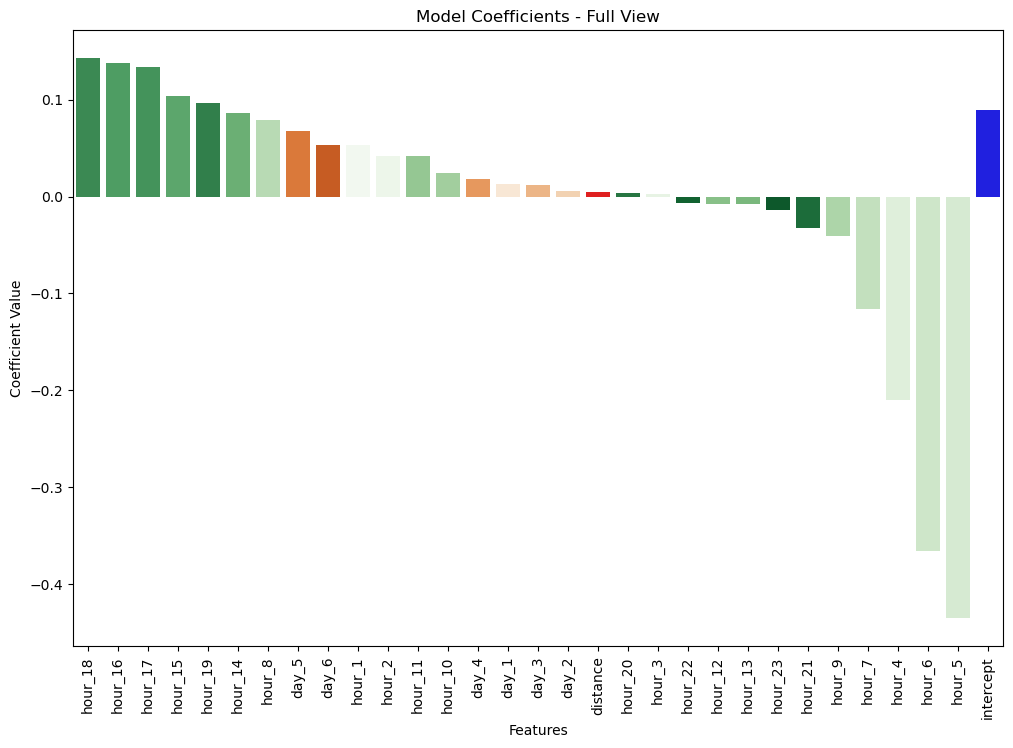

In [17]:
# Creating our multi-linear regression model, predicting the travel time based on the previous parameters and the hour of the day
## Splitting our data using my_train_test_split function
y = df_model1_dummies_hour['travel_time']
X = df_model1_dummies_hour.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our new model 1: model1_day_hour
model1_day_hour = LinearRegression()
model1_day_hour.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day_hour, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1_day_hour = model1_day_hour.predict(X_test)
s_model1_day_hour_validation = build_validation_serie(y_test, y_pred_model1_day_hour)
display(s_model1_day_hour_validation)

## Plotting 3 bar plots of the model's coefficients
### Plotting the first bar plot with the intercept, the distance and the days of the week
df_days = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('day_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_days.index, y='Coefficient', data=df_days.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Days of the Week')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the second bar plot with the intercept, the distance and the hours of the day
df_hours = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('hour_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_hours.index, y='Coefficient', data=df_hours.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Hours of the Day')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the last bar plot with all the coefficients and setting 2 different colors
### for the intercept and the distance, and setting 2 different gradient for the hours of the day
### and the days of the week
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model1_coeffs.index:
    if idx == 'intercept':
        colors.append('blue')
    elif idx == 'distance':
        colors.append('red')
    elif idx.startswith('day_'):
        colors.append(plt.cm.Oranges(int(idx.split('_')[1]) * 30))
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    else:
        colors.append('gray')
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

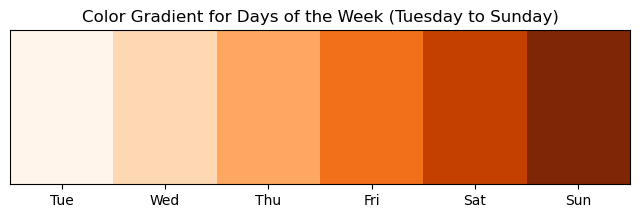

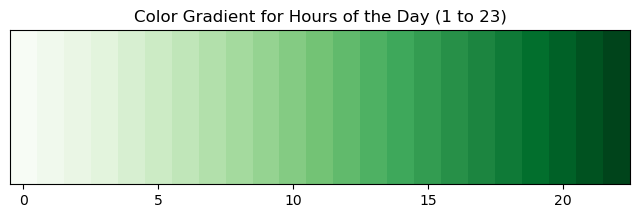

In [18]:
# Plotting a legend for the previous code that plotted the complete bar graph
## Plotting a gradient to show the colors grading from Tuesday to Sunday (1 to 6)
plt.figure(figsize=(8, 2))
gradient_days = np.linspace(0, 1, 6).reshape(1, -1)
plt.imshow(gradient_days, aspect='auto', cmap='Oranges')
plt.title('Color Gradient for Days of the Week (Tuesday to Sunday)')
# Changing the legend to show the days of the week
plt.xticks(ticks=np.arange(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.show()

## Plotting a gradient to show the colors grading from Hour 1 to Hour 23
plt.figure(figsize=(8, 2))
gradient_hours = np.linspace(0, 1, 23).reshape(1, -1)
plt.imshow(gradient_hours, aspect='auto', cmap='Greens')
plt.title('Color Gradient for Hours of the Day (1 to 23)')
plt.yticks([])
plt.show()

In [19]:
# Estimating 15km travel times with different hours of the day and days of the week with model1_day_hour
TT_15km_model1_day_hour = {}
for day in range(7):
    for hour in range(24):
        # Creating a dataframe with the distance, day and hour
        data = {'distance': [15000]}
        for d in range(1, 7):
            data[f'day_{d}'] = [1 if d == day else 0]
        for h in range(1, 24):
            data[f'hour_{h}'] = [1 if h == hour else 0]
        X_temp = pd.DataFrame(data)
        # Predicting the travel time
        TT_15km_model1_day_hour[(day, hour)] = model1_day_hour.predict(X_temp)[0]

# Displaying the estimated travel times for a 15km trip in a dataframe
df_TT_15km_model1_day_hour = pd.DataFrame.from_dict(TT_15km_model1_day_hour, orient='index', columns=['Estimated Travel Time (minutes)'])
df_TT_15km_model1_day_hour.index = pd.MultiIndex.from_tuples(df_TT_15km_model1_day_hour.index, names=['Day of the Week', 'Hour of the Day'])
df_TT_15km_model1_day_hour = df_TT_15km_model1_day_hour.sort_index()
df_TT_15km_model1_day_hour.sample(10)

Estimated Travel Time (minutes)
Day of the Week Hour of the Day                                 
0               15                                     74.308333
2               20                                     74.214201
6               12                                     74.250856
2               12                                     74.203316
1               5                                      73.781844
6               15                                     74.361957
3               20                                     74.220502
                4                                      74.006706
5               14                                     74.358820
                11                                     74.314215

In [21]:
from functions.estimator import MLR_model_estimator

# Example
test_distance = 15000  # in meters
test_travel_time = None  # unknown, to be predicted
test_datetime_1h = '2020-01-07 08:15:00'  # example datetime
test_day = 1  # Tuesday
test_month = 1  # January

sample_list = [test_distance, test_travel_time, test_datetime_1h, test_day, test_month]
pred = MLR_model_estimator(
    model=model1_day_hour,
    features=sample_list,
    feature_names=['distance','travel_time','datetime_1h','day','month'],
    model_feature_names=X.columns,   # X is the training DataFrame's columns used to fit the model
    show_steps=True
)
print(f"The predicted travel time for a {test_distance/1000} km trip is: {round(pred)} minutes")

[STEP] Starting estimation
[STEP] Extracted base features: {'distance': 15000, 'day': 1, 'datetime_1h': '2020-01-07 08:15:00', 'month': 1}
[STEP] distance = 15000.0
[STEP] Using provided day = 1
[STEP] Derived hour from datetime_1h = 8
[STEP] Using provided month = 1
[STEP] Using provided model_feature_names
[INFO] model will expect 30 features: ['distance', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
[STEP] Built input vector (first 10 values shown): [1.5e+04 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00]
[STEP] Model intercept = 0.08931234831123547
[STEP] Model has 30 coefficients; input vector length = 30
[RESULT] Predicted travel time = 74.29589625033238
The predicted travel time for a 15.0 km trip is: 74 

#### c/ Adding the weather